In [1]:
import os
import random
import json
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from typing import List, Tuple, Set, Dict
%matplotlib inline

In [2]:
with open("./results/wav2vec2_results.json") as file:
    wav2_vec2_res: Dict = json.load(file)

In [3]:
val_PER_per_layer = []
for layer in wav2_vec2_res["layers"]:
    layer_pers = []
    for head in wav2_vec2_res["val_per"][layer]:
        layer_pers.append(wav2_vec2_res["val_per"][layer][head])
    val_PER_per_layer.append(layer_pers)

In [4]:
test_PER_per_layer = []
for layer in wav2_vec2_res["layers"]:
    layer_pers = []
    for head in wav2_vec2_res["test_per"][layer]:
        layer_pers.append(wav2_vec2_res["test_per"][layer][head])
    test_PER_per_layer.append(layer_pers)

In [5]:
val_PER_per_layer = np.array(val_PER_per_layer)
test_PER_per_layer = np.array(test_PER_per_layer)

# Results

In [6]:
def plot_layer_accuracy_hist(val_per: np.ndarray, test_per: np.ndarray, head_idx: int, heads: List[str], ssl_model: str) -> None:
    layers = np.arange(len(val_per)) + 1

    plt.figure(figsize=(8, 5))
    width = 0.4
    
    if head_idx != -1:
        plt.bar(layers - width/2, val_per[:, head_idx], width=width, label="Validation PER", alpha=0.7)
        plt.bar(layers + width/2, test_per[:, head_idx], width=width, label="Test PER", alpha=0.7)
    else:
        val_per_avg = np.average(val_per, axis=1)
        test_per_avg = np.average(test_per, axis=1)
        plt.bar(layers - width/2, val_per_avg, width=width, label="Validation PER", alpha=0.7)
        plt.bar(layers + width/2, test_per_avg, width=width, label="Test PER", alpha=0.7)

    plt.xlabel(f"{ssl_model} Layer")
    plt.ylabel("PER")
    if head_idx != -1:
        plt.title(f"{ssl_model} Layer PER Distribution for {heads[head_idx]} head")
    else:
        plt.title(f"Average Layer PER Distribution")
    plt.xticks(layers)
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.show()


def plot_model_accuracy_hist(val_per: np.ndarray, test_per: np.ndarray, layer_idx: int, heads: List[str], ssl_model: str) -> None:
    heads_idx = np.arange(len(heads)) 

    plt.figure(figsize=(8, 5))
    width = 0.4

    if layer_idx != -1:
        plt.bar(heads_idx - width/2, val_per[layer_idx], width=width, label="Validation PER", alpha=0.7)
        plt.bar(heads_idx + width/2, test_per[layer_idx], width=width, label="Test PER", alpha=0.7)
    else:
        val_per_avg = np.average(val_per, axis=0)
        test_per_avg = np.average(test_per, axis=0)
        plt.bar(heads_idx - width/2, val_per_avg, width=width, label="Validation PER", alpha=0.7)
        plt.bar(heads_idx + width/2, test_per_avg, width=width, label="Test PER", alpha=0.7)


    plt.xlabel("Heads")
    plt.ylabel("PER")
    if layer_idx != -1:
        plt.title(f"Head PER Distribution for {ssl_model} Layer {layer_idx + 1}")
    else:
        plt.title(f"Average Head PER Distribution")
    plt.xticks(heads_idx, heads, rotation=45)
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.show()


def plot_best_layers_hist(val_per: np.ndarray, test_per: np.ndarray, heads: List[str], ssl_model: str) -> None:
    best_layers = np.argmin(val_per, axis=0)
    best_val_per = val_per[best_layers, np.arange(len(best_layers))]
    best_test_per = test_per[best_layers, np.arange(len(best_layers))]

    heads_idx = np.arange(len(heads))

    plt.figure(figsize=(8, 5))
    width = 0.4

    plt.bar(heads_idx - width/2, best_val_per, width=width, label="Validation PER", alpha=0.7)
    plt.bar(heads_idx + width/2, best_test_per, width=width, label="Test PER", alpha=0.7)

    for i, layer in enumerate(best_layers):
        plt.text(i, best_val_per[i] + 0.005, f"L{layer + 1}", ha='center', fontsize=10, color='blue')

    plt.xlabel("Heads")
    plt.ylabel("PER")
    plt.title(f"Best {ssl_model} Layer PER Across Heads")
    plt.xticks(heads_idx, heads, rotation=45)
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.show()


def plot_best_heads_hist(val_per: np.ndarray, test_per: np.ndarray, heads: List[str], ssl_model: str) -> None:
    best_heads = np.argmin(val_per, axis=1)
    best_val_per = val_per[np.arange(len(best_heads)), best_heads]
    best_test_per = test_per[np.arange(len(best_heads)), best_heads]
    layers = [i for i in range(1, len(val_per) + 1)]
    layers_idx = np.arange(len(layers))

    plt.figure(figsize=(8, 5))
    width = 0.4

    plt.bar(layers_idx - width/2, best_val_per, width=width, label="Validation PER", alpha=0.7)
    plt.bar(layers_idx + width/2, best_test_per, width=width, label="Test PER", alpha=0.7)

    for i, head in enumerate(best_heads):
        plt.text(i, best_val_per[i] + 0.005, heads[head], ha='center', fontsize=10, color='blue')

    plt.xlabel(f"{ssl_model} Layers")
    plt.ylabel("PER")
    plt.title("Best Head PER Across Layers")
    plt.xticks(layers_idx, layers, rotation=45)
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.show()

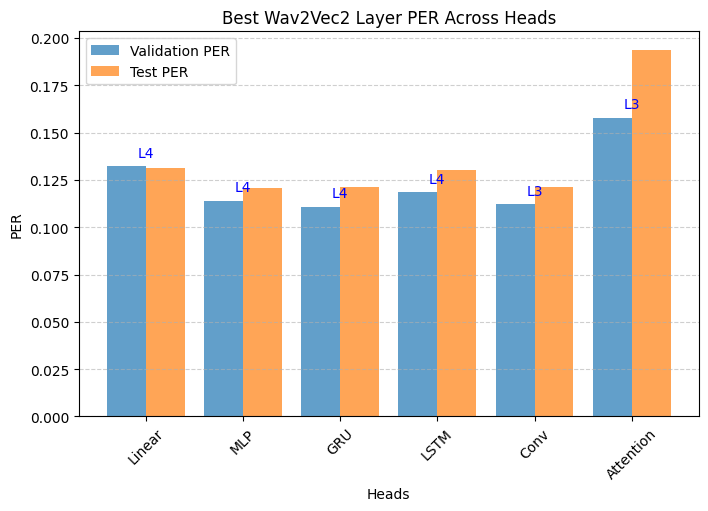

In [7]:
plot_best_layers_hist(val_PER_per_layer, test_PER_per_layer, heads=wav2_vec2_res['heads'], ssl_model="Wav2Vec2")

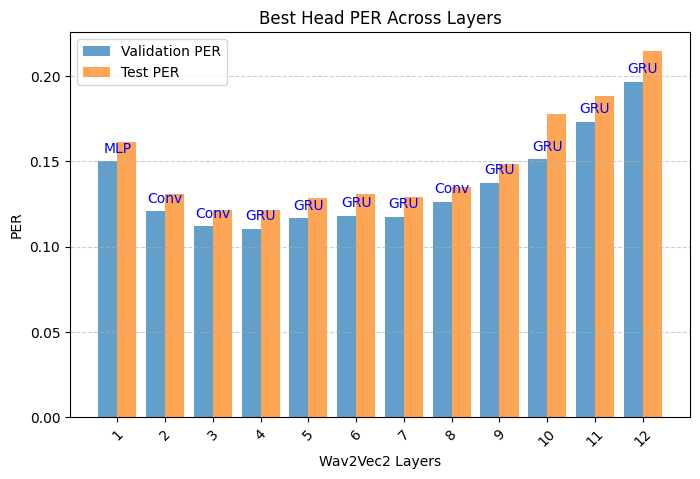

In [8]:
plot_best_heads_hist(val_PER_per_layer, test_PER_per_layer, heads=wav2_vec2_res['heads'], ssl_model="Wav2Vec2")

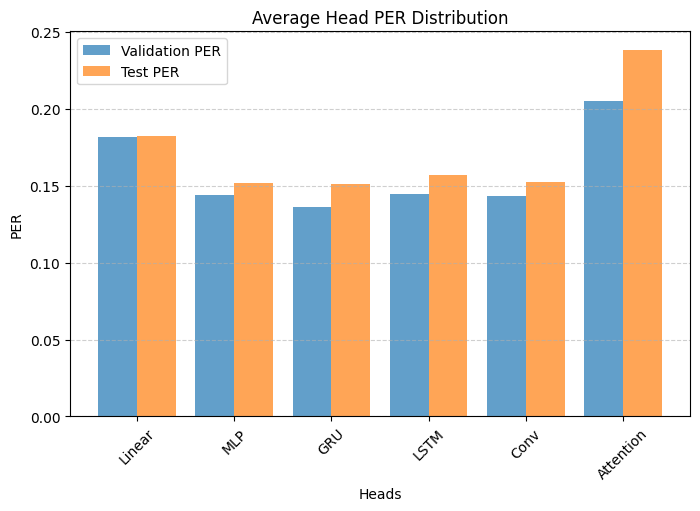

In [9]:
plot_model_accuracy_hist(val_PER_per_layer, test_PER_per_layer, layer_idx=-1, heads=wav2_vec2_res['heads'], ssl_model="Wav2Vec2")

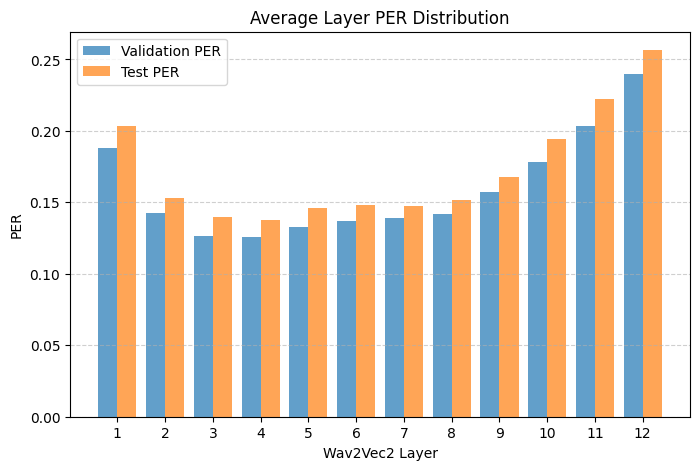

In [10]:
plot_layer_accuracy_hist(val_PER_per_layer, test_PER_per_layer, head_idx=-1, heads=wav2_vec2_res['heads'], ssl_model="Wav2Vec2")

From this, we can conclude that for the phoneme recognition task, the most informative features in Wav2Vec2 are extracted from the fourth hidden layer from the end, and the best-performing Head is the GRU. The best overall result achieved with Wav2Vec2 was a PER of **0.1106** on the validation dataset and **0.1209** on the test dataset. This is slightly worse than the result reported by the original [Wav2Vec2](https://arxiv.org/pdf/2006.11477) authors (**0.116**).